<a href="https://colab.research.google.com/github/nightted/Travel-Recommend-project/blob/main/Googlemap_Store_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A project to recommend the hotels according to the surrounding stores and attractions

---
# Outline :

1.  根據 All餐廳s + All 便利商店s "密度" (有人 Prefer "安靜" , 有人愛 "鬧區與便利"), 以及想吃&去的 target store 位置( EX: 牛肉湯,肉燥飯,觀光景點,網美餐廳...) & 密度來選擇住的區域 (還在發想要不要加入 ratings 來做選擇的 weighting)
2.  選擇區域後 , 再根據區域內 target store 分布 , 以及機能密度 , 以及"想去的景點"(演算法待想) , 來選擇區域內的一個 center 來當搜尋中心點. 
3.  根據中心點 , 抓初 circle 範圍內一定的推薦數量(User control)的 hotels , 並根據 user 所設的 criteria ( ratings , 民宿or飯店類型 ...) 來 filter hotels 
4. 從 booking 爬取及時房況 (直接一間一間 POST filter 出來的 hotels ?) 並呈現在頁面上.
https://colab.research.google.com/drive/1gpdM-l18V49edFp4I1_mR5p6ilcHRc2_
---

# Hotel object construction 流程上的定義 :

-> 利用 Gmap API 建立 hotel 基本資訊 (name , location ,google_rating) 

-> 確認 hotel 房源 , **並交叉比對房源上的是不是真的存在此 hotel

-> 確認完後 , 建立 (room_source , source_name)

-> 利用目前 attribute:(name , location ,google_rating , room_source ,
  source_name) 來建立 store objects

---

# (12/3 update 最新版) 交叉比對房源方法 :

1. 利用 Place id as search input , 並用 booking name 與 google name 做字串比對.
2. 先 Name judge : If 比對相似字串長度 > 2 , 則 judge pass .
3. 再 Distance judge : If distance(google_latlng , booking_latlng) < 300 , 則 judge pass .
4. 兩項 judge 皆須通過才算通過判別

---

# (11/24) 目前已解決大部分問題 , 目前剩餘 bugs : 
1. (已修正) 距離太近的兩家 hotel 還是會誤判成同一間 (EX: 鬍子趣 and 沙龍)
2. (尚無解) 不同名字但同一間的 (EX: TopL and 鼎立安) ,距離稍遠會造成烙高
3. (已修正) 在同一棟裡面無法處理 ,會判別成同一棟XD (沐藍輕旅 and 九月)
4. (已修正) 中英字母判別相同須為連續字母 ( abcdef and fedcba 會被判別成同一個) 

---









#TODO LIST
1. #TODO(Done) : sightseeing spot and 網美景點
2. #TODO : 決定選區演算法 (Done , see current idea)
3. #TODO(Done by 11/13) : 把 store data class 化的必要? (精簡程式碼)
*  Current idea :

*   step.1 算出美食與便利店密度, 當作機能指標 (Done , 11/6 新增 rating_depent ,
      11/7 修改 grid_generator 新增 'normal' mode)
*   step.2 尋找機能密度 peak , 抓出前幾大 peak 的位置 (這邊如果有加入想去的景點選
      項, peak 選擇可加入此條件考量 , EX: 離景點最近的 peak) 
*   step.3 找到 peak 後 , 按 peak 所在的 grid 做上下左右的搜索 , 並設置 target 
      S =  機能密度 x 想吃的食物數目(要考慮評價 ,利用 radius search)  

4. #TODO : 飯店附近推薦美食 , 需用 googlesearch package 來抓google搜尋blog結果 

5. #TODO : add adddress into  class attribute




In [2]:
!pip install googlemaps

  Created wheel for googlemaps: filename=googlemaps-4.4.2-cp36-none-any.whl size=37858 sha256=f76848c2bb7afcff54cba08ea14755806e5a26c95c25bcfc8751e4649e4e5e0a
  Stored in directory: /root/.cache/pip/wheels/f4/21/41/0c84572e21d52bb322f6c299f38ac7cd8ad6d4d6ce23dc3631
Successfully built googlemaps


In [1]:
b = [1,2,3,4,5,6]

def judge(num):
    if num > 3:
        return num
    else:
        return None  

f = filter(judge ,b)
f = list(f)
f

[4, 5, 6]

In [3]:
import googlemaps
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from sklearn.cluster import KMeans
import datetime 
import time as t
import os 
import seaborn as sns
import math 
from functools import partial , reduce  
import requests
from bs4 import BeautifulSoup
import re
import asyncio
import random 

def save_pkl(path  , data):
    with open(path , "wb") as pkl :
        pickle.dump(data , pkl)
        
def load_pkl(path):
    with open(path , "rb") as pkl :
        data = pickle.load(pkl) 
    return data

# GLOBAL VARIABLE    
key_path = '/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/API_KEY/API_KEY.txt'
storage_path = '/content/drive/MyDrive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Object data'
name_transform = load_pkl('/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Object data/Hotel_name_transform.pickel')
url = "https://www.booking.com/searchresults.zh-tw.html"
header_url = "https://www.booking.com"
lng_1 = 102.516520*1000 # 1 longitude to meters
lat_1 = 110.740000*1000 # 1 latitude to meters
location = {'lat': 22.9913113, 'lng': 120.198012} # position of center of tainan (春川煎餅)

# The range of lat,lng of Taiwan
Admin_area_range_lng = [120.03786531340755 , 122.00991123709818]
Admin_area_range_lat = [21.871068186336803 , 25.30245194059663]

In [ ]:
# Saving Data (Tainan)
#save_pkl(os.path.join(storage_path , 'Tainan_all_objects') , Tainan_all_objects)

In [ ]:
restart = 334
for idx , hotel in enumerate(Tainan_hotel):

  if idx >= restart :
    print(f'Now in [{idx+1}/{len(Tainan_hotel)}] : {hotel.name}')

    # compare hotel name between gmaps and booking 
    hotel.main_construct_step( distance_threshold = 300.0 )
    print('\n')

    if idx % 10 == 0:
      save_pkl('/content/drive/MyDrive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Tainan_hotel' , Tainan_hotel)
      # compare error in 宜蘭暮夏villa and 暮夏villa

Now in [335/430] : 台南民宿幸福拾光
The google map name is : 台南民宿幸福拾光
['2020-12-15', '2020-12-16']
{'ss': '台南', 'ssne': '台南', 'ssne_untouched': '台南', 'dest_type': 'region', 'dest_id': None, 'place_id': 'ChIJTyp9COJ1bjQRgI7UFYj955o'}
台南幸福拾光 台南幸福拾光
The booking search name is : 台南民宿幸福拾光
latlng_booking : [120.175484, 22.985622] , latlng_gmap : [120.1754807,22.9855969] 
Distance = 2.800085992657343 meters
There is 6 same words ['台南幸福拾光']
Booking contain this hotel : 台南民宿幸福拾光


Now in [336/430] : Flora Inn, Tainan
The google map name is : Flora Inn, Tainan
['2020-12-15', '2020-12-16']
{'ss': '台南', 'ssne': '台南', 'ssne_untouched': '台南', 'dest_type': 'region', 'dest_id': None, 'place_id': 'ChIJW_CvTYl3bjQRDNHk6nRIT0s'}
FloraInnTainan 花水木
The booking search name is : 花水木民宿 
latlng_booking : [120.16518272, 23.0008345] , latlng_gmap : [120.1651824,23.0009259] 
Distance = 10.121689162411563 meters
There is 0 same words None
This hotel 花水木民宿  is not the same hotel as Flora Inn, Tainan!


Now in [337/430] : 

# Main function and Store class define

In [4]:
# read API_KEY 
def read_key(key_path):
  with open(key_path , 'r') as f:
    KEY = f.read()
  return KEY

# find if english word in string 
def find_english_char(string):

  '''
  function : find english alphabet in string or not 

  input :
    #string : the string mix with alphabet in 
  
  rtype : 
    #bool : if True , means alphabet in 

  '''
  for chr in string:
    if chr.encode('UTF-8').isalpha():
      return True
  return False

# get the all continus digits in string
def get_digits(text):

  '''
  function : get all successive digits in string 

  input :
    #text : the string mix with digit in 
  
  rtype : 
    #collect : list of successive digits in string 

  '''
  dummy = ''
  collect = []
  for idx ,chr in enumerate(text):

    if chr == ',':
      continue
      
    if chr.isdigit():
      dummy += chr
    if not chr.isdigit() or idx == len(text)-1:
      if len(dummy) > 0:
        collect.append(dummy) 
        dummy = ''
      else:
        continue

  return collect

# Check the place is in target admin_area or not
def check_place_in_range(lnglat , Admin_area_range_lng , Admin_area_range_lat):
  
  try:
    lng = lnglat['lng']
    lat = lnglat['lat']
  
  # if the argumaent is None
  except TypeError:
    return True

  return Admin_area_range_lng[0]<lng<Admin_area_range_lng[1] and Admin_area_range_lat[0]<lat<Admin_area_range_lat[1]
                  
# generate grid of position by radius
def grid_generator( location , radius , ranging , mode = "max_area"):
    
    '''
    function : generate search points (grid)

        @ is scan point in grid

        mode 'normal : @--2*r--@--2*r--@--2*r--@--2*r--@ 
                @--2*r--@--2*r--@--2*r--@--2*r--@

        mode 'max_area' :    @--2*r--@--2*r--@--2*r-- 
                    --2*r--@--2*r--@--2*r--@

        mode 'full_cover' :  @-r-@-r-@-r-@-r-@ 
                    @-r-@-r-@-r-@-r-@ 
    input :
      #location : search center (grid start generating from this point) 
      #radius : interval between grid point
      #ranging : number of search points to generate in top,bottom,left,right ( 1 ranging equal to generate 2 points about 1 radius interval in "full-cover" mode)
    
    rtype : 
      #grid : grids of position
    '''

    rg = [ i for i in range(ranging,-(ranging+1),-1) ] #　get list between [int , -int]
    grid_delta_lng = radius / lng_1 # unit transform between meter and lat,lng  ( 1000m radius <=> 0.01 lag ,lng )
    grid_delta_lat = radius / lat_1

    lng , lat = location['lng'] , location['lat']
    # get the grids 
    grid_outer = [ {'lng': lng + grid_delta_lng *2* lng_delta , 'lat': lat + grid_delta_lat *2* lat_delta } for lng_delta in rg for lat_delta in rg ]

    if mode == 'max_area':
      grid_inner = [ {'lng': dicts['lng'] - grid_delta_lng  , 'lat': dicts['lat'] - grid_delta_lat } for dicts in grid_outer ]
      
      return grid_outer + grid_inner

    if mode == 'full_cover':
      grid_inner = [ {'lng': dicts['lng'] - grid_delta_lng  , 'lat': dicts['lat'] - grid_delta_lat } for dicts in grid_outer ]
      grid_down = [ {'lng': dicts['lng']  , 'lat': dicts['lat'] - grid_delta_lat } for dicts in grid_outer ]
      grid_aside = [ {'lng': dicts['lng'] - grid_delta_lng  , 'lat': dicts['lat']  } for dicts in grid_outer ] 

      return grid_outer + grid_inner + grid_down + grid_aside

    return grid_outer 

def extract_address_by_geocode(maps , store_name):
  
  '''
  function : address extraction 

  input :
    #maps : google map client 
    #store_name : store you want to extract address
  
  rtype :
    #address : address of store
  '''
  
  address , lnglat = geocode_subprocess(maps , store_name)
  
  if check_place_in_range(lnglat , Admin_area_range_lng , Admin_area_range_lat) :
    return address
  else:
    print('[WARNING] This place is not in Taiwan!') 
     
  return None 

def geocode_subprocess(maps , store_name):
  
  '''
  function : sub-process of address extraction 
  
  input :
    #maps : google map client 
    #store_name : store you want to extract address
  
  rtype : 
    #address : address of store
    #lnglat : latitude , longitude of store
  
  '''

  # administrative level : 
  # postal_code(區碼) > country(國) > administrative_area_level_1(市) > administrative_area_level_2 > administrative_area_level_3(區) > route(路街巷) > street_number(號) > subpremise(樓)
  administrative_level = {
    "postal_code_suffix" : 10,
    "postal_code" : 9,
    "country" : 8,
    "administrative_area_level_1" : 7 ,
    "administrative_area_level_2" : 6 ,
    "administrative_area_level_3" : 5 ,
    "locality" : 4,
    "route" : 3 ,
    "street_number" : 2 ,
    "subpremise" : 1 ,
    "establishment" : 0 ,
    "neighborhood" : -1
  }

  # There's 2 condition return empty address and latlng
  # 1. geocoding can't find the store name 
  # 2. result of geocoding for administrative level goes wrong
  
  geo_res = maps.geocode( store_name , language='zh-TW' ) 
  if not geo_res:
    print(f'[WARNING] No such hotel found in geocode : {store_name}!')
    return None , None 

  try :
    address = [ level_ad['long_name'] for level_ad in sorted( geo_res[0]['address_components'] 
                                    ,reverse=True 
                                    ,key=lambda x: administrative_level[x['types'][0]]) 
                                      if not find_english_char(level_ad['long_name'])  ] # get address by administrative level
  # if the administrative level goes wrong 
  except KeyError:
    print('Something wrong with the address!')     
    return None , None                                
  
  address = ''.join(address) # combine address by administrative level
  address = address + get_digits(geo_res[0]['formatted_address'])[0] + '號' if '號' not in address else address # if not contain '號' ,get No. in formatted_address 
  address = address[3:] # remove 7XX postal code
  
  lnglat = geo_res[0]['geometry']['location']

  return address , lnglat


# get store information with location , keyword , search radius  
def store_scraper( maps,
          keyword , 
          location , 
          location_admin , 
          radius , 
          next_page_token , 
          objects , 
          store_type = None ):

    '''
    function : get stores with keyword in some radius

    input:
      #keyword : keyword of store you want to search 

      #location : search center

      #location_admin : administrative name of area 

      #radius : search radius

      #next_page_token : to get data of page 20~40 , 40~60  

      #objects : objects already storage (list)

      #store_type : tpye of store (ex: hotel , rest , ...)
    
    rtype:
      #next_page_token : to get data of page 20~40 , 40~60 

      #objects : store or hotel objects found

    '''

    if objects == None:      
        objects = []

    res = maps.places_nearby( page_token = next_page_token , keyword = keyword , location = location , radius = radius , language = 'zh-TW')   #get stores list nearby   
    t.sleep(1)
    for store_inform in res['results']:

        lat_lng = store_inform['geometry']['location']
        lat , lng = lat_lng['lat'] , lat_lng["lng"]
        store_name = store_inform['name']
        place_id = store_inform['place_id']
        rating = store_inform.get('rating',None)

        # exclude stores not contains ratings
        if rating:

            # TODO : Handling address representation in this part (這邊試著把它打包起來XD).
            try:
            # In this part , there's 2 kind of ERROR here
            # 1. The address we got contains English words (We need chinese!!!)
            # 2. Can't get the address directly from store_inform dictionary (KeyError)
            # when encounters this 2 condition , use the geocode() to get address again. 
              address = store_inform['plus_code']['compound_code'].split(' ')[-1] + store_inform['vicinity']
              if find_english_char(address):
                # In this part , there's also 2 kind of WARNINGs here
                # 1. The geocode returned isn't in locality
                # 2. The geocode can't find any result (including truly not found or admin level fail)
                # when encounters this 2 condition , use the original address we got. 
                print(f'[ENGLISH ERROR] {store_name} change to geocode !')
                extract_address = extract_address_by_geocode(maps , store_name) 
                address = extract_address if extract_address != None else address

            # if key error when finding address , special handling 
            except KeyError:
              print(f'[KEYERROR ERROR] {store_name} change to geocode !')
              extract_address = extract_address_by_geocode(maps , store_name) 
              address = extract_address if extract_address != None else address

            address = address.split('號')[0] + '號' # remove following char after '號' and 70X at head , EX : 700中西區海安路256號一樓 => 中西區海安路256號
            information = {  'lng' : lng , 
                      'lat' : lat , 
                      'store_name' : store_name , 
                      'rating' : rating ,
                      'admin_area' : location_admin ,
                      'address' : address , 
                      'place_id' : place_id
                    } 
                      
            store_obj = Store(store_type , dicts = information) if store_type != 'hotel' else Hotel(store_type , dicts = information) # create store or hotel objects

            if store_obj not in objects : # discard None-rating store and add new items if it's not already exsit
              objects.append(store_obj)

        else :
          print(f"[WARNING] {store_name} doesn't contains rating !")
          continue
        
        
    next_page_token = res.get( 'next_page_token' , None ) # get if token exsit or return None 

    return next_page_token  , objects

# get store information with location , keyword , search radius (plus the change pages and move search location)
# 1 ranging is across 2 * radius in each sides  
# EX : radius = 1000 , ranging = 1 , so the spanning region is 2000 in top,bottom,left,right directions , total scan area = 4000 X 4000 .
def moving_store_scraper( maps,
              keyword , 
              search_center , 
              admin_area , 
              radius , 
              ranging , 
              next_page_token = None , 
              objects = None , 
              store_type = None ,
              mode = "max_area" ):

    '''
    function : get stores with keyword in range of grid

    input:
      #keyword : keyword of store you want to search 

      #location : search center 

      #radius : search radius

      #next_page_token : to get data of page 20~40 , 40~60  

      #objects : objects already storage (list) 

    rtype :
      #objects : store or hotel objects found 

    '''
    
    search_points = grid_generator(search_center , radius , ranging , mode = mode)
    for idx , location in enumerate(search_points): 

        print(f'finish [{idx+1}/{len(search_points)}] parts !')       
        while True : # change page
            next_page_token ,  objects = store_scraper(maps , 
                                    keyword , 
                                    location , 
                                    admin_area , 
                                    radius , 
                                    next_page_token = next_page_token , 
                                    objects = objects , 
                                    store_type = store_type)
            if next_page_token == None :
                break
            t.sleep(3) #set time sleep to avoid request too often !
    return objects

def update_new_stores(**kwargs):

  '''
  wait extend ...
  '''
  pass

# store weighting
def rating_modify(rating):
    
    if  4.8 < rating <= 5.0 :
        score = 512.0
    elif 4.6 < rating <= 4.8 :
        score = 256.0
    elif 4.4 < rating <= 4.6 :
        score = 128.0
    elif 4.2 < rating <= 4.4 :
        score = 64.0
    elif 4.0 < rating <= 4.2 :
        score = 32.0
    elif 3.8 < rating <= 4.0 :
        score = 16.0
    elif 3.6 < rating <= 3.8 :
        score = 8.0
    elif 3.4 < rating <= 3.6 :
        score = 4.0
    elif 3.2 < rating <= 3.4 :
        score = 2.0
    else:
        score = 1.0
    
    return score

def distance(a , b):

    '''
    get distnace of two point (in unit of meter)
    '''
    a_x , a_y = a[0] , a[1]
    b_x , b_y = b[0] , b[1]
    delta_x_meter = (a_x-b_x)*lng_1
    delta_y_meter = (a_y-b_y)*lat_1

    return ((delta_x_meter)**2 + (delta_y_meter)**2 )**0.5


In [5]:
# send request and return soup result 
def send_request( url , method = 'GET' , data = None , headers = None ):

  if method == "GET":
    res = requests.get(url , headers = headers)
  elif method == "POST":
    res = requests.post(url , data = data , headers = headers)
  else :
    print("[WARNING] No request method assigned!")

  res = res.content
  soup = BeautifulSoup(res , 'html.parser')

  return soup


#INPUT type scrape_time : ['2020-12-09' ,'2020-12-10']
def get_header_payload(scrape_time  , target_hotel = None , place_id = None , destination_admin = None):

  '''
  # function : get the headers and payload by scrape time

  target_hotel : if it's not assigned , scarpe all "台南" hotel 

  '''

  check_in_time = scrape_time[0].split('-')
  check_out_time = scrape_time[1].split('-')

  if target_hotel :
    
    payload_destination = {
      'ss': target_hotel , 
      'ssne': destination_admin , # place you want to search (encode)
      'ssne_untouched': destination_admin , # place you want to search (encode)
      'dest_type': 'hotel' , 
      'dest_id': None , # place id you want to search 
    }
    

  elif place_id:

    payload_destination = {
      'ss': destination_admin , 
      'ssne': destination_admin , # place you want to search (encode)
      'ssne_untouched': destination_admin , # place you want to search (encode)
      'dest_type': 'region', 
      'dest_id': None , # place id you want to search 
      'place_id' : place_id  
    }

  else:
    raise NameError('Need to assign hotel name or place id !')

  print(payload_destination)
  payload = {
    'checkin_year': check_in_time[0] ,
    'checkin_month': check_in_time[1] ,
    'checkin_monthday': check_in_time[2] ,
    'checkout_year': check_out_time[0] ,
    'checkout_month': check_out_time[1] ,
    'checkout_monthday': check_out_time[2] ,
    'aid': '1288258', # need or not?
    'label': 'gen173nr-1DCAEoggI46AdIM1gEaOcBiAEBmAEwuAEXyAEM2AED6AEBiAIBqAIDuAKJ6b39BcACAdICJGNhNDI0OWE4LWI3OTEtNGJmZi1hYzc3LWQ2NTgyNzFlNTlmYdgCBOACAQ', # need or not?
    'sid': '496ffe4644cfaa958be35e8693a2ba9c', # need or not?
    'sb': '1', # need or not?
    'src': 'searchresults', 
    'src_elem': 'sb', # need or not?
    'is_ski_area': '0', # need or not?
    'group_adults': '2', # number of people
    'group_children': '0', # number of children
    'no_rooms': '1', # number of rooms
    'from_sf': '1', # ???
    'ac_langcode': 'xt' ,
  }

  payload.update(payload_destination)

  headers = {    
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36', # can be generate fake agent ??
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'error_url': "https://www.booking.com/index.zh-tw.html?aid=1288258;label=metagha-link-mapresultsTW-hotel-2468603_dev-desktop_los-1_bw-18_dow-Monday_defdate-0_room-0_lang-zh_curr-TWD_gstadt-2_rateid-0_aud-0_cid-_gacid-6642513825_mcid-10_ppa-0_clrid-0_ad-1_gstkid-0;sid=ab79516c4eea1e96b378b9c2338022ce;sb_price_type=total;srpvid=f1b826d7eb680028&;",
    'content-security-policy-report-only': "report-uri https://csp-receiver.booking.com/csp_violation?type=report&tag=112&pid=040f2610ef80010a&e=UmFuZG9tSVYkc2RlIyh9YRdubXl3m7MIPItwv4TRRzARPrDvNuzlrbfIvmyYAyhkeKKOaHLiHXalz9oYwBjSNw&f=2&s=0; frame-ancestors 'none';",
    'Referer' : 'https://www.booking.com/index.zh-tw.html?aid=376396&label=booking-name-yefrPbbyS%2AFIINHgyCnmNgS267725091255%3Apl%3Ata%3Ap1%3Ap22%2C563%2C000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-65526620%3Alp1012818%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YfqnDqqG8nt1O4nYvDr1lms&sid=99dd5960476d5bf057cf94fe33e3deb6&srpvid=6d1e3723a19e0104&click_from_logo=1',
    'Host': 'www.booking.com',    
    'Upgrade-Insecure-Requests': '1',
    'Accept-Language': 'zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1' ,
    'Connection': 'keep-alive'
  }
  
  return payload , headers

# check target information in search result or not
def check_alive_or_not( search_result , text = True , tag  = None , msg_if_none = None ):
  '''
  text : if True , get text in tag ; if False , get tag property

  tag : if not none , get property of that tag
  '''
  if not search_result:
    return msg_if_none
  return search_result.text if text else search_result[tag]


def get_date_string(delta_day = 0):

  return (datetime.datetime.now()+datetime.timedelta(days=delta_day)).strftime("%Y-%m-%d")

# get information of hotels
def get_hotel_information( hotel_name = None , 
              place_id  = None ,
              date = None ,  
              instant_information = False ,
              destination_admin = None ,
              url = "https://www.booking.com/searchresults.zh-tw.html" ):

  '''
  #function : get hotel information including non-instant or instant data by hotel_name or place id

  hotel_name : name of hotel in "booking or agoda" website

  place_id : place id of hotel in gmaps (represent accurate position information like address)

  date : day to check-in and check-out , ex: ['2020-12-10','2020-12-11']

  instant_information : if True , get instant information ( price , avaliable number of rooms , room_recommend )


  '''

  if not destination_admin:
    raise NameError('Need to know administrative area !')

  if not hotel_name and not place_id :
    raise NameError('Need to assign hotel_name or place_id !')

  if instant_information and not date:
    raise NameError('Instant information need to assign date!')

  
  if not instant_information:

    y_m_d = get_date_string(7).split('-')

    # 這邊是為了避掉周末會沒房源,可能會造成 gmaps & booking 房源名字比對時的錯誤(如果沒房源會抓不到那間飯店!) 
    if datetime.datetime.now().isoweekday() in [5,6,7]: 
      date = [get_date_string(3),get_date_string(4)] 
    else :
      date = [get_date_string(0),get_date_string(1)]
  
  print(date)
  
  payload , headers = get_header_payload( date , 
                        target_hotel = hotel_name , 
                        place_id = place_id , 
                        destination_admin = destination_admin )
  
  NotFinish , retry = True , 0
  while NotFinish:


    soup = send_request( url , method = 'POST' , data = payload , headers = headers )
    try: 
      soup_content = soup.find_all( "div" , { 'class' : "sr_item_content sr_item_content_slider_wrapper "})[0]
      soup_pic = soup.find_all( "div" , { 'class' : "sr_item_photo sr_card_photo_wrapper"})[0]
      NotFinish = False 

    except IndexError:

      retry += 1 
      if retry > 5:
        return {} # retry too many time , return empty dicts

      print(f'Soup content error , retry {retry} times!')
    
  return extract_informations_from_soup( soup_content , soup_pic , instant_information )

# extract information from soup
def extract_informations_from_soup( soup_content , soup_pic , instant_information = False ):

  '''
  # function : extract information from soup

  soup_content , soup_pic : content of soup

  instant_information : if True , get instant information ( price , avaliable number of rooms , room_recommend )
  '''

  # p class="simple_av_calendar_no_av sold_out_msg"
  if instant_information :
    ### get below <div class="sr_item_content sr_item_content_slider_wrapper ">
    room_soldout = bool(soup_content.find('p' , { 'class' : "simple_av_calendar_no_av sold_out_msg"}))
    if room_soldout:
      return {'room_recommend' : '太夯了!!已售完!!' ,
           'room_remainings' : '太夯了!!已售完!!' ,
           'hot' : '太夯了!!已售完!!' ,
           'price' : '太夯了!!已售完!!' ,
           'instant_hrefs' : '太夯了!!已售完!!' }
    #print(soup_content.prettify())
    hotel_room_recommend = soup_content.find('div', {'class':"room_link"}).find('strong').text # get the recommend romm type  (instant information)
    hotel_room_remainings = check_alive_or_not(soup_content.find('span', {'class':"only_x_left sr_rooms_left_wrap "}), msg_if_none = '房源還很充足!' ).rstrip("\n").strip("\n") # get remaining rooms (instant information)
    hotel_hot = check_alive_or_not(soup_content.find('div' , {'class' : 'rollover-s1 lastbooking'}) , msg_if_none = '快上網站訂房!').rstrip("\n").strip("\n") # get the hot of hotels (instant information) 不是每個hotel都有此block !!!!!
    hotel_price = int( get_digits( str(soup_content.find('div' , { 'class' : "bui-price-display"})).split('€')[1] )[0] )
    hotel_instant_hrefs = soup_content.find('a', {'class':"js-sr-hotel-link hotel_name_link url"})['href'].strip("\n") # get room_hrefs

    # !!BUGS: price 部分有 /xa0124 encode 的問題
    return {'room_recommend' : hotel_room_recommend ,
          'room_remainings' : hotel_room_remainings ,
          'hot' : hotel_hot ,
          'price' : hotel_price , # remove /xa0 
          'instant_hrefs' : hotel_instant_hrefs }


  else :
    ### get below <div class="sr_item_content sr_item_content_slider_wrapper ">
    hotel_hrefs = soup_content.find('a', {'class':"js-sr-hotel-link hotel_name_link url"})['href'].strip("\n") # get room_hrefs 
    # these items below may not exist
    hotel_rating = check_alive_or_not( soup_content.find( "div" , { 'class' : "bui-review-score__badge"}) )
    hotel_comment_num = check_alive_or_not( soup_content.find('div' , {"class" : "bui-review-score__text"}) ) # get # of comments 
    hotel_star = check_alive_or_not( soup_content.find('span' , {'class' : "bui-rating bui-rating--smaller" }) , text = False , tag = 'aria-label') # get star of hotel 

    ### get below <div class="sr_item_photo sr_card_photo_wrapper" id="hotel_5621655">
    hotel_pic_link = soup_pic.find('img' , {'class' : "hotel_image" })['data-highres'] # get hotel review pic

    return {  "href": hotel_hrefs , 
          "comment_num": hotel_comment_num ,
          "stars": hotel_star ,
          "pic_link": hotel_pic_link ,
          "source_rating": hotel_rating 
                          }
          

In [ ]:
GOOGLE_API_KEY = read_key(key_path)
maps = googlemaps.Client(key = GOOGLE_API_KEY)

In [ ]:
def compare_str(pattern , string):

  '''
  function : find similar and successive pattern in strings

  input:
    #pattern : the pattern to find
    #string : the target string  

  rtype :
    #char_similar_list　: the list of similar parts in target string 
  '''

  similar_collect_list = []
  all_similar_list = []

  for step , char in enumerate(pattern) :
    #print('char:',char)
    #print(step , char)
    if char in string :
      #print('char inner:',char)
      # EX: similar_collect_list = [ [14,15] ,[22,23] ,[1,2,3,4] ...]
      if similar_collect_list:
        
        # collect index of successive appeared char 
        remove_collect_list = [] # define remove list to store non-successive chars
        for idx_collector in similar_collect_list:

          #print('idx_collector[-1]+1:',idx_collector[-1]+1 ,'char : ' , char)

          if idx_collector[-1] + 1 < len(string) and string[idx_collector[-1] + 1] == char :
            idx_collector.append(idx_collector[-1] + 1) # collect index of successive appeared char 
          else:
            all_similar_list.append(idx_collector)
            remove_collect_list.append(idx_collector)
          
          similar_collect_list = [ collector for collector in similar_collect_list if collector not in remove_collect_list ]
        
        # collect index of new appered char
        remove_new_list = [] # define remove list to store appeared chars
        new_set = list(re.finditer(char , string)) # find the position of target char
        for idx in new_set:
          for collector in similar_collect_list:
            if idx.start() in collector:
               remove_new_list.append(idx.start())

        new_set = [ [idx.start()] for idx in new_set if idx.start() not in remove_new_list ]

        similar_collect_list = similar_collect_list + new_set # combine the indexs of new appeared and successive appeared char 
        
        #print("collect exsit !",similar_collect_list) 

      # for step = 0 or all the collectors in similar_collect_list was collected to all_similar_list (for current pattern char "not" in s case)
      else:
        similar_collect_list = [ [idx.start()] for idx in re.finditer(char , string) ]

      #print("similar_collect_list" , similar_collect_list)

    else:
      if similar_collect_list:
        all_similar_list += similar_collect_list
        similar_collect_list.clear()
      else:
        continue 
    
  if similar_collect_list:
    all_similar_list += similar_collect_list
  char_similar_list = [ ''.join([string[idx] for idx in collector ]) for collector in all_similar_list ] # convert to strings 

  return char_similar_list 

def find_common_word_2str(str1 , str2):

  '''
  function : find similar and successive chars between 2 strings 

  input:
    #string : the target string  

  rtype :
    #max_len_similar 　: the max number of similar chars  
  '''
  
  str1 = re.sub('[ ()!?/,‧+•【】.:飯店民宿-]','', str1)
  str2 = re.sub('[ ()!?/,‧+•【】.:飯店民宿-]','', str2)
  similar_str = compare_str(str1 , str2)

  if not similar_str:
    return 0 , None 

  else:
    len_list = [len(char) for char in similar_str]
    max_len_similar = max(len_list) # find the max len of similar and successive chars
    max_len_idx = [i for i , j in enumerate(len_list) if j == max_len_similar]
    max_len_chars = [similar_str[idx] for idx in max_len_idx ]
  
  return max_len_similar , max_len_chars

In [6]:
# define an class-Store to encapsulate the creating function and attribute of stores
# initialize items => name , source_name(after name-matching) , location , google_rating
class Store(object):

  def __init__(self , store_type = None , dicts = None):
    self.store_type = store_type
    if dicts is not None:
      self.construct_basic_attr( dicts )
  
  def construct_basic_attr(self , store_dict):
    # basic attribute
    self.name = store_dict['store_name']
    self.lng = store_dict['lng']
    self.lat = store_dict['lat']
    self.rating = store_dict['rating']
    self.admin_area = store_dict['admin_area']
    self.address = store_dict['address']
    self.place_id = store_dict['place_id']

  def __repr__(self):
    return f'{self.store_type} : {self.name} in {self.admin_area} and rating {self.rating} in googlemap '

  #https://stackoverflow.com/questions/6423814/is-there-a-way-to-check-if-two-object-contain-the-same-values-in-each-of-their-v
  def __eq__(self , other):
    # need to modified , ex : compare dict['name'] or dict['address'] ....
    return self.__dict__ == other.__dict__

  def __getitem__(self , ):
    pass
    # TODO : 打 self.name 就能回傳物件


class Hotel(Store):

  def __init__(self , store_type = 'hotel' , dicts = None):
    super().__init__( store_type , dicts )

  def main_construct_step(self , distance_threshold = 300.0 ):

    print(f'The google map name is : {self.name}')

    # First step : Name judgement (gmap name vs. booking name) by sending place_id or gmap name search request   
    inform_dict , detail_inform_dict = get_detail_hotel_information(place_id = self.place_id , destination_admin = self.admin_area )

    if inform_dict and detail_inform_dict:

      name_booking = detail_inform_dict['name_booking']
      common_word_count , max_len_chars = find_common_word_2str(self.name , name_booking) 
      name_judge = common_word_count >= 2 

      '''
      if not name_judge:
        inform_dict , detail_inform_dict = get_detail_hotel_information(hotel_name = self.name , destination_admin = self.admin_area )
        name_booking = detail_inform_dict['name_booking']
        common_word_count , max_len_chars = find_common_word_2str(self.name , name_booking) 
        name_judge = common_word_count >= 2
      '''

      print(f'The booking search name is : {name_booking}')

      # Second step : distance judgement (by place id input and get latlng result)
      latlng_gmap , latlng_booking = [self.lng , self.lat] , detail_inform_dict['latlng_booking']
      delta_distance = distance(latlng_gmap , latlng_booking)
      distance_judge = delta_distance < distance_threshold 

      print(f'latlng_booking : {latlng_booking} , latlng_gmap : [{self.lng},{self.lat}] ')
      print(f'Distance = {delta_distance} meters')
      print(f'There is {common_word_count} same words {max_len_chars}')

      if name_judge and distance_judge:
        # "PASS" name comparison , construct static property !
        self.room_source = 'booking'
        self.source_name = name_booking 
        self.construct_static_attr({**inform_dict , **detail_inform_dict}) 
        # self.save()

        print(f'Booking contain this hotel : {name_booking}')

      else:
        # "NOT PASS" name comparison ,not construct static property here !
        self.room_source = None
        self.source_name = None 
        # self.save()

        print(f'This hotel {name_booking} is not the same hotel as {self.name}!')
    
    else:
      self.room_source = None
      self.source_name = None 
      # self.save()

      print(f"Can't find this hotel {name_booking}'s information !")

  
  def construct_static_attr(self , store_dict ):
  
    # Detail property (from booking or agoda ..) 
    if getattr(self,'room_source',None) and getattr(self,'source_name',None): # check room source exsit 
      
      if self.room_source == 'booking':
        
        # update static data
        if 'href' and 'source_rating' in store_dict.keys(): # check one of the keys is in dict

          self.detail_href = store_dict['href']
          self.comment_num = store_dict['comment_num']
          self.star = store_dict['stars']
          self.pic_link = store_dict['pic_link']
          self.source_rating = store_dict['source_rating']
          self.pics = store_dict['pics'] # from inner pages
          self.comments = store_dict['comments'] # from inner pages

        else:
          print('[WARNING] Not contains more information !')
    
      elif self.room_source == 'agoda':
        pass

      elif self.room_source == 'Hotel.com':
        pass
    
    else:
      print('[WARNING] Need to get room_source and source_name !')
  

  def construct_instant_attr(self , date = get_date_string()): 
  
    if getattr(self,'room_source',None) and getattr(self,'source_name',None):

      # Instant property (from booking or agoda ..) 
      if self.room_source == 'booking' :

        self.date = date # date if not assign , default today 
        if self.date != None:
          
          instant_dict = get_hotel_information( hotel_name = self.source_name , 
                              date = date , 
                              destination_admin = self.admin_area , 
                              instant_information = True )

          self.room_recommend = instant_dict['room_recommend'] 
          self.room_remainings = instant_dict['room_remainings'] 
          self.hot = instant_dict['hot']
          self.price = instant_dict['price']
          self.instant_hrefs = instant_dict['instant_hrefs']

          #if self.room_remainings == '太夯了!!已售完!!':




          # TODO : 這邊要給一個例外, 如果 room_recommend ,room_remainings 等等皆為已售完 , 則抓取前後一天房源 ! (需有個地方儲存以便顯示)
          # => get_hotel_information( self.source_name , date = date +/- 1,2 ,  instant_information = True )
        else :
          print('[WARNING] No date assigned!')
      
        # 此處用在第一次建立 hotel objects 時所用 
        
      elif self.room_source == 'agoda:':
        pass
      else :
        pass

    else:
      print('[WARNING] Need to get room_source and source_name !')

  def __repr__(self):
    return super().__repr__()

  def __eq__(self , other):
    return super().__eq__(other)



def get_detail_hotel_information(hotel_name = None , place_id = None , destination_admin = None ):
  
  '''
  Function : getting booking information together by "hotel_name" or "place_id" 

  # hotel_name : hotel_name in google maps

  # place_id : place id in google maps 

  # retrun_name : return name and inform dict or not
  '''

  if not hotel_name and not place_id :
    raise NameError('Need to offer name of hotel or place_id!')
  
  inform_dict = get_hotel_information( hotel_name = hotel_name, 
                      place_id = place_id , 
                      destination_admin = destination_admin) 
  
  if inform_dict:
    href = inform_dict['href']
    new_url = header_url + href
    soup_sub = send_request( new_url ,method = "GET" )

    # soup of commnet part
    soup_comment = soup_sub.find_all( 'p' , { 'class' : 'trackit althotelsReview2 fixed_review_height fixed_review_top_align review_content'})
    comments = [ item.text.rstrip("\n").strip("\n") for item in soup_comment ]

    # soup of pics part 
    soup_pic = soup_sub.find_all("a" , { 'class' : 'bh-photo-grid-item'})
    pics = [ item['href'] for item in soup_pic ]

    # soup of latlng part
    latlng_booking = soup_sub.find( 'a' , {'id' : "hotel_sidebar_static_map" })
    latlng_booking = latlng_booking['data-atlas-latlng'].split(',')
    latlng_booking = [ float(latlng_booking[1]) , float(latlng_booking[0]) ]

    # soup of booking name part 
    name_booking = soup_sub.find( 'h2' , {'id' : 'hp_hotel_name'}).text.split('\n')[2]

    detail_inform_dict = {
      'comments' : comments ,
      'pics' : pics ,
      'latlng_booking' : latlng_booking ,
      'name_booking' : name_booking
    }
  
  else:
    detail_inform_dict = {}

  return inform_dict , detail_inform_dict

In [7]:
# load grid to latlng data 
grid_to_latlng = load_pkl('/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Gird_to_latlng/grid_to_latlng')

# load object data (store & hotel objects)
Tainan_all_objects = load_pkl(os.path.join(storage_path ,'Tainan_all_objects'))
Tainan_train_station = load_pkl(os.path.join(storage_path ,'Tainan_train_station'))
Tainan_resturant = load_pkl(os.path.join(storage_path ,'Tainan_resturant'))
Tainan_beefsoup = load_pkl(os.path.join(storage_path ,'Tainan_beefsoup')) 
Tainan_nightmarket = load_pkl(os.path.join(storage_path ,'Tainan_nightmarket'))
Tainan_con = load_pkl(os.path.join(storage_path ,'Tainan_con'))
Tainan_hotel = load_pkl(os.path.join(storage_path ,'Tainan_hotel'))
Tainan_sightseeing = load_pkl(os.path.join(storage_path ,'Tainan_sightseeing'))
Tainan_gruel = load_pkl(os.path.join(storage_path ,'Tainan_gruel'))
Tainan_EelNoodles = load_pkl(os.path.join(storage_path ,'Tainan_EelNoodles'))
Tainan_porkrice = load_pkl(os.path.join(storage_path ,'Tainan_porkrice'))

# load density data (numpy array)
density_rs = load_pkl('/content/drive/MyDrive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Density data /density_rs')
density_h = load_pkl('/content/drive/MyDrive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Density data /density_h')
density_cn = load_pkl('/content/drive/MyDrive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Density data /density_cn')
density_bs = load_pkl('/content/drive/MyDrive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Density data /density_bs')
density_eel = load_pkl('/content/drive/MyDrive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Density data /density_eel')
density_gru = load_pkl('/content/drive/MyDrive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Density data /density_gru')
density_porkrice = load_pkl('/content/drive/MyDrive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Density data /density_porkrice')

# Main step of construct the Booking.com hotels and store object

# Get position , rating , name data as np array

In [9]:
# grab the store contain some keyword (ex: 扁食)
def grab_keyword_store( store_objs , keyword = ''):

  '''
  # function : transform data to numpy

  data : list of store objects

  keyword : to filter keyword in store_name

  '''
 
  x ,y , x_y , rat , name = [] , [] , [] , [] , []
  for store_obj in store_objs:
    if keyword in store_obj.name : # if keyword == None , grab all stores
      x.append(store_obj.lng)
      y.append(store_obj.lat)
      x_y.append([store_obj.lng , store_obj.lat])
      #rat.append(rating_modify(item['rating'])) # rating func 要修正XD , EX: 4.8~5.0 => 10 分 , 4.6~4.8 => 9 分 , ... , < 3.0 => 1分
      rat.append(store_obj.rating)
      name.append(store_obj.name)

  return x , y , x_y , rat ,name

In [ ]:
x_rs , y_rs , x_y_rs , rating_rs , name_rs = grab_keyword_store(Tainan_resturant) # All 餐廳s
x_tr , y_tr , x_y_tr , rating_tr , name_tr = grab_keyword_store(Tainan_train_station)             # train station 
x_bf , y_bf , x_y_bf , rating_bf , name_bf = grab_keyword_store(Tainan_beefsoup , "牛肉湯")         # 牛肉湯
x_nm , y_nm , x_y_nm , rating_nm , name_nm = grab_keyword_store(Tainan_nightmarket , 'Night Market')    # 夜市
#x_pr , y_pr , x_y_pr , rating_pr , name_pr = grab_keyword_store(data_porkrice , '肉燥飯')         # 肉燥飯
x_cn , y_cn , x_y_cn , rating_cn , name_cn = grab_keyword_store(Tainan_con)                  # 便利超商
x_h , y_h , x_y_h , rating_h , name_h = grab_keyword_store(Tainan_hotel)                    # 飯店 
x_sight , y_sight , x_y_sight , rating_sight , name_sight = grab_keyword_store(Tainan_sightseeing)       # 觀光景點
x_Eel , y_Eel , x_y_Eel , rating_Eel , name_Eel = grab_keyword_store(Tainan_EelNoodles)            # 鱔魚意麵
x_gru , y_gru , x_y_gru , rating_gru , name_gru = grab_keyword_store(Tainan_gruel)               # 鹹粥

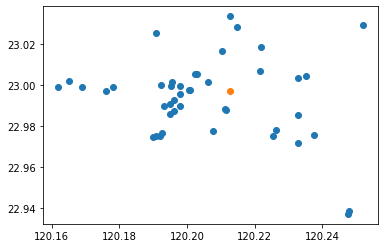

In [ ]:
#plt.scatter(np.array(x_y_rs)[:,0],np.array(x_y_rs)[:,1])    # 餐廳
#plt.scatter(np.array(x_y_bf)[:,0],np.array(x_y_bf)[:,1]) # 牛肉湯
#plt.scatter(np.array(x_y_Eel)[:,0],np.array(x_y_Eel)[:,1]) # Eel
plt.scatter(np.array(x_y_gru)[:,0],np.array(x_y_gru)[:,1]) # gru
#plt.scatter(np.array(x_y_nm)[:,0],np.array(x_y_nm)[:,1]) # 夜市
#plt.scatter(np.array(x_y_pr)[:,0],np.array(x_y_pr)[:,1]) # 肉燥飯
#plt.scatter(np.array(x_y_cn)[:,0],np.array(x_y_cn)[:,1]) # 便利商店
#plt.scatter(np.array(x_y_h)[:,0],np.array(x_y_h)[:,1]) # hotel
plt.scatter(np.array(x_y_tr)[:,0],np.array(x_y_tr)[:,1]) # train station

# Grouping the stores


In [ ]:
[ [f'Group: {idx} ,', center ]  for idx , center in enumerate(kmeans.cluster_centers_)]

[['Group: 0 ,', array([120.19347102,  22.97808337])],
 ['Group: 1 ,', array([120.23780087,  23.02699732])],
 ['Group: 2 ,', array([120.22860748,  22.98752553])],
 ['Group: 3 ,', array([120.19532757,  23.03690482])],
 ['Group: 4 ,', array([120.1690571 ,  22.99526288])],
 ['Group: 5 ,', array([120.23990803,  22.95767118])],
 ['Group: 6 ,', array([120.20533248,  23.00215255])]]

In [ ]:
# grouping the x_y data by KM result to specified group 
def Grouping_data_by_zone(data , KM_label , group ): 

  return [ ele for idx , ele in enumerate(data) if KM_label[idx] == group ]
  
# grouping the target stores by KM result 
def Grouing_target_store_by_zone(x_y_target , KM_center):

  cluster_num = len(KM_center)
  group = np.zeros(len(x_y_target))

  for store_idx , position in enumerate(x_y_target):
    min = 1000000000
    for center_idx , cluster_center in enumerate(KM_center): 
      if distance(position , cluster_center) < min :
        min = distance(position , cluster_center)
        group_idx = center_idx

    group[store_idx] = group_idx
  return group

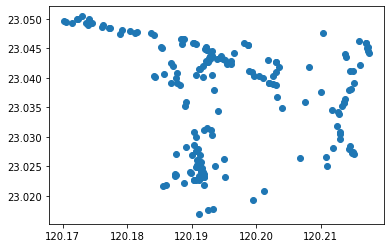

In [ ]:
data = x_y_rs
group_idx = 3

x_y_g = Grouping_data_by_zone(data , kmeans.labels_ , group_idx )
plt.scatter(np.array(x_y_g)[:,0],np.array(x_y_g)[:,1])

In [ ]:
target_store_label = Grouing_target_store_by_zone( x_y_rs , KM_center = kmeans.cluster_centers_ ) # get the grouping label of target store
store_rating_by_label = [ Grouping_data_by_zone( rating_rs , target_store_label , i ) for i in range(len(kmeans.cluster_centers_)) ] # by the grouping label , get the store ''information'' by zone
store_rating_by_label_ave = [ np.average(np.array(rating_score)) for rating_score in store_rating_by_label ] # rating ave. of every zone 
store_rating_by_label_ave

[4.306976744186047,
 4.229130434782609,
 4.3091205211726376,
 4.1866666666666665,
 4.2945,
 4.1988304093567255,
 4.301086956521739]

In [ ]:
# calculate the foucs_center where "best-food" is clutering at 
# TODO: need to modify due to new definition of target and surrounding stores
x_focus , y_focus = (x*rating).sum() / rating.sum() , (y*rating).sum() / rating.sum()
x_focus , y_focus

# Density calculation

In [29]:
# Calculate local density of stores
def local_density(
        data_objects ,            # form = [ object1 , object2  , ..... ]
        rating_depent = False ,  # use modified rating score or not
        group_idx = None ,     # if it's none setting , start point is defalut as "Tainan Train Station"
        start_point = {'lat': 22.9913113, 'lng': 120.198012}  ,    # start point of scan (Default : 春川煎餅)
        jump_distance = 100 ,   # interval of scan spot
        ranging = 20 ,       # scan range
        scan_distance = 300 ,    # scan radius of circle or side length of rectangle
        scan_shape = "rectan"   # shape of scan area 
        ):
  
  #transform density array to matrix
  def density_matrix_form(density_array):

    '''
    now data process direction :
    y axis : lat
    x axis : lng
      --------- y axis (j) -------> 
      |
      x

      a
      x
      i
      s

      (i)
      |
      V
    '''
    # get the length of grid square
    d = np.zeros(( int((len(density_array))**0.5) , int((len(density_array))**0.5 ))) # density matrix 
    p = np.zeros(( int((len(density_array))**0.5) , int((len(density_array))**0.5 ))).tolist() # position matrix 
    i , j = 0 , -1 

    for idx , (posi , densi) in enumerate(sorted(density_array , key = lambda x : x[0])):

      if idx == 0:
        dummy_x = posi[0]
      if dummy_x == posi[0]: #if lng not change ,only change the write-in row(j+)
        j+=1  
      else: #if lng change , change the write-in column(i+)
        i+=1
        j=0
        dummy_x = posi[0]
      d[i][j] = densi
      p[i][j] = posi # how to rotate 90 degree ???
    p = np.array(p)

    return np.rot90(d , k=1) , np.rot90(p, k=1, axes = (0,1)) # rotate 90' counterclockwise to fit x-y direction

  # initialize density list ,Rho ,start point
  density = [] 
  MAX_Rho , MAX_position = 0 , None # max Rho and position 

  # initialize grids , judge function
  scan_mode = 'full_cover' if ranging > 0 else 'normal' # if ranging = 0 , single point scan , using normal mode for grid 
  grid_positions = grid_generator(start_point , radius = jump_distance , ranging = ranging , mode = scan_mode) # set search grids initialization
  grid_positions = [ [ position["lng"] , position["lat"] ] for position in grid_positions ]
  # x[0] present position , x[1] present rating!
  
  for now_position in grid_positions:
    # TODO (Done by 11/14): 這地方直接綁 store object 似乎更好? 直接 filter( judge_func , object ) 出來 , output 是符合條件的 objects !!!
    # 也不會有 judge function 那邊 x[0] 這種還要給 index 的狀況出現 !! 可改成 lambda x , pos : distance( object.location ,pos) < criteria
    # 這樣 lambda function 就可以獨立出來 ,跟 store_filter_by_radius function 做結合!!!
    filter_objs = filter_store_by_criteria( data_objects , 
                          center = now_position , 
                          criteria = scan_distance , 
                          scan_shape = scan_shape )   
    store_counts = [ rating_modify(obj.rating)/512 if rating_depent else 1 for obj in filter_objs ] #point[1] is the rating score (consider into Rho calculate) ;if not consider rating_depent ,set as 1
    Rho = sum(store_counts)/(math.pi*(scan_distance/1000)**2) if scan_shape == "circle" else sum(store_counts)/((2*scan_distance/1000)**2) # calculate density

    #store data
    density.append(  [now_position , Rho ] ) 
    (MAX_Rho , MAX_position) = (Rho , now_position) if Rho > MAX_Rho else (MAX_Rho , MAX_position)  # store max value

  print(f'MAX_Rho = {MAX_Rho} , MAX_position = {MAX_position}')

  return density_matrix_form(density) , MAX_Rho , MAX_position 


def filter_by_criteria( obj , center , criteria , scan_shape = 'rectan' ):

  # Judge if whether it's hotel object,
  # if so , check room_source exsit or not ; if not , set as True (belong to resturant or con)
  if hasattr(obj , 'room_source'):
    selectable = True if getattr(obj , 'room_source') else False # for handling hotel type store
  else:
    selectable = True

  if scan_shape == "circle":
    return [obj , distance( [obj.lng , obj.lat] , center )] if distance( [obj.lng , obj.lat] , center ) < criteria else None
  elif scan_shape == 'rectan':
    return [obj , distance( [obj.lng , obj.lat] , center )] if abs(obj.lng - center[0])*lng_1 < criteria and abs(obj.lat - center[1])*lat_1 < criteria and selectable else None

def filter_store_by_criteria(objs , center , criteria , scan_shape = 'rectan'):
  
  judge_func = partial( filter_by_criteria , 
              center = center , 
              criteria = criteria , 
              scan_shape = scan_shape ) # use partial func to pre-init params pos => https://wiki.jikexueyuan.com/project/explore-python/Functional/partial.html
   
  filtered_stores = list(map( judge_func , objs ) ) # get # of points inside circle or rectangle 
  filtered_stores = list(filter(None.__ne__ , filtered_stores))

  return filtered_stores

In [12]:
density_position_rs  , MAX_Rho_rs , MAX_position_rs = local_density( Tainan_all_objects['Tainan_resturant'] , rating_depent = True ,  scan_shape = 'rectan' , ranging = 40 )

MAX_Rho = 25.520833333333336 , MAX_position = [120.2028892627085, 22.997632412515802]


In [30]:
filter_store_by_criteria(Tainan_all_objects['Tainan_resturant'] , center=[location['lng'] , location['lat']] , criteria=500 , scan_shape='circle')

[[Resturant : Serendipity 不經意的美好 by 熹餐廳 in 台南 and rating 4.7 in googlemap ,
  384.39790537711764],
 [Resturant : 朱熹漢堡 in 台南 and rating 4.6 in googlemap , 384.39790537711764],
 [Resturant : 村長餐廳 in 台南 and rating 4.3 in googlemap , 362.971743108481],
 [Resturant : 榮膳餐廳 in 台南 and rating 4.3 in googlemap , 397.6913001349805],
 [Resturant : 發現蝸牛。幸福食堂 in 台南 and rating 4.4 in googlemap , 277.7959573605507],
 [Resturant : JaM Pizzeria Cafe in 台南 and rating 4.8 in googlemap ,
  225.96445973689384],
 [Resturant : Nest炭火燒肉專門 in 台南 and rating 4.8 in googlemap ,
  421.51086472176956],
 [Resturant : 月燒肉便當 in 台南 and rating 4.5 in googlemap , 396.2593279188284],
 [Resturant : 洋蔥咖哩工房 in 台南 and rating 4.3 in googlemap , 271.43834749760197],
 [Resturant : 蛸屋本舖 in 台南 and rating 4.5 in googlemap , 430.5153551698524],
 [Resturant : 松竹號當歸鴨 in 台南 and rating 4.2 in googlemap , 399.89601605489213],
 [Resturant : 鉄輪 ジンギスカン in 台南 and rating 4.2 in googlemap , 470.286202496275],
 [Resturant : 陶板屋 台南忠義店 in 台南 and r

In [14]:
b = [1,2,3,4,5,6]

def judge(num):
    if num > 3:
        return num
    else:
        return None  

f = map(judge ,b)
f = list(f)
f

[None, None, None, 4, 5, 6]

# Finding the top10 hightest density position "consider hotels distribution"


In [ ]:
# finding the top10 hightest density position "consider hotels distribution"
def search_peak(silence_demand = False , target_sigtseeings = None , **kwargs):

  '''
  function : search peaks from density grid maps

  silence_demand : if True , choose place 鬧中取靜XD .

  target_sigtseeings : target sightseeing customer want to go , type as : ['sightseeing1','sightseeing2']

  **kwargs : the basic density maps you want to consider , ex : (density_rs = density_rs , density_h = density_h .. )

  return : peaks with [ position_x(grid) ,position_y(grid) , density of resturant center , scors of center]

  '''
  # initialize weights and threshold  

  # the minimun score of point to find (it's too far out of city if score less than this value!)
  demand_threshold = 3 

  # the weights of basic density(for local popularity) , including: hotel , resturant , con_store density
  basic_weights = { 
      'rs' : 1 ,
      'cn' : 0.5 , 
      'h' : 0.25 
  }

  # the weights of specail food(You want to eat!) density , such : porkrice , eulnooles , beefsoup .. 
  food_weights = 5

  # corrected weight for silence demand (from get min -> max ,so add negative weight -1)
  corrections = [1]*len(kwargs) if not silence_demand else [-1]*len(basic_weights)+[1]*(len(kwargs)-len(basic_weights))  

  
  # initialize data of train_station and sightseeing (for 1/r wighting use)
  station_position = [[Tainan_train_station[0].lng , Tainan_train_station[0].lat]]
  if target_sigtseeings:
    sightseeing_positions = get_latlng_directly(target_sigtseeings)
  else:
    sightseeing_positions = []
  all_positions = station_position + sightseeing_positions


  # initialize data of density
  peaks = []
  density_stack = np.array([ density for _ , density in kwargs.items() ]) # stack the all the densitys 
  density_name = [name.split('_')[1] for name in kwargs.keys()] # all the name of densitys => [rs , cn , h , bs , pr ..]
  shape_W_L = density_stack.shape[1]

  # main loop for finding peaks
  for i in range(shape_W_L):
    for j in range(shape_W_L):

      surrounding = [ [k,l] for k in range(i-1,i+2) for l in range(j-1,j+2) if (k!=i or l!=j) and (shape_W_L>k>0 and shape_W_L>l>0) ] # find surranding 8 positions
      
      # score of surroundings
      density_surroundings = [ density_stack[ : , pos_x , pos_y] for pos_x , pos_y in surrounding ]
      score_surrounding = [] 
      for density_surrounding in density_surroundings:
        score = 0
        for correction , name , density in zip(corrections , density_name , density_surrounding):
          score += correction *basic_weights.get( name , food_weights ) *density
        score_surrounding.append(score)

      # score of center
      density_center = density_stack[ : , i , j ]
      score = 0
      for correction , name , density in zip(corrections , density_name , density_center):
        score += correction *basic_weights.get( name , food_weights ) *density
      score_center = score

      # if center larger than all surroundings and larger than minimun threshold , keep the point
      if len(list(filter(lambda x : x < score_center , score_surrounding) )) == 8 and abs(score_center) > demand_threshold:
        
        positions_distance = list(map(lambda x : distance(grid_to_latlng[i][j] , x ) , all_positions)) # distance from current position to all_positions
        positions_distance_weighting = sum([1000.0/distance for distance in positions_distance]) # calculate 1/r weights for all_positions
        peaks.append(list(grid_to_latlng[i][j]))    
                #list(density_center) , 
                #positions_distance ,
                #score_center*positions_distance_weighting ])
      else:
        continue

  # sort peaks by scores
  peaks = sorted(peaks , reverse=True , key = lambda x : x[1]) 

  return peaks

def get_latlng_directly( positions ):

  # In Django ORM , adjust to find in Class.object.all() 
  position_latlng = []
  for position in positions:

    Find_flag = False 
    for store_obj in Tainan_sightseeing:
      if store_obj.name == position :
        Find_flag = True
        position_latlng.append([store_obj.lng , store_obj.lat])

    if not Find_flag:
      res = maps.geocode(position)
      location = res[0]['geometry']['location']
      position_latlng.append([location['lng'] , location['lat']])

  return position_latlng





1.   Resturant , convenience store , hotel => 喜愛熱鬧程度
2.   Sightseeing , Nightmarket => 特殊景點指定
3.   Beefsoup , EulNoodles , Porkrice => 特殊美食指定




*   詢問選項1 : 喜愛熱鬧嗎? Ans : Yes or No
*   詢問選項2 : 有必去的景點嗎? Ans : EX 安平古堡 , 四草綠色隧道 or No 

    => If Yes : 針對目標景點做 1/r^2 加成

    => If No : 不特別針對目標景點做加成
*   詢問選項3 : 有想吃的食物嗎? Ans : EX 肉燥飯 ,牛肉湯 or No 

    => If Yes : 針對選項一 ,二得出的 top20 peaks ,random 挑 top10 peaks, 針對特

      殊食物類型店家做 circle search , 最終挑出 search result topN points (N<10)

      (這邊記得要儲存 TopN 周圍 circle search 到的 target food 店家!)

    => If No : 不特別針對特殊食物類型店家做加成(最終判定就從 Top10 random 挑) 
*   最終判定 : 由選項三挑出的 each TopN position , 

    each 往外擴找到最近的一個hotel object 並回傳.

    (如果兩個top找到的是同一間 , 則任選一個top再外擴找一間)
  




In [ ]:
# remember to load density data first!

def find_best_hotels(peaks , silence_demand = False ,target_sigtseeings = None , target_food = None , **kwargs ):

  # hash 
  hash_name_obj_density = {
      '牛肉' : ['Tainan_beefsoup' , 'density_bs'] ,
      '肉燥' : ['Tainan_porkrice' , 'density_porkrice'] , 
      '鱔魚' : ['Tainan_EelNoodles' , 'density_eel']  ,
      '鹹粥' : ['Tainan_gruel' , 'density_gru'] 
  }

  # add target food density for density stackings
  select_food = []
  for key_food in hash_name_obj_density.keys():
    for food in target_food:
      if find_common_word_2str(food , key_food)[0] >= 2:
        select_food.append(key_food)
  select_food = list(set(select_food))  
  food_dict = { hash_name_obj_density[food][1] : eval(hash_name_obj_density[food][1]) for food in select_food }    
  kwargs = { **kwargs , **food_dict }

  # main step to find suitable hotels
  top_peaks = search_peak( silence_demand = silence_demand , 
                target_sigtseeings = target_sigtseeings , 
                **kwargs )
  
  top_points = find_top_points_by_target_food( top_peaks ,
                          target_food = target_food ) 



In [ ]:
topN = 50
randomN = 3
silence_demand = False
target_sigtseeings = ['四草綠色隧道','安平古堡']
target_food = ['文章牛肉湯']
kwargs = {'density_h' : density_h , 'density_rs' : density_rs , 'density_cn' : density_cn }

In [ ]:
hash_name_obj_density = {
    '牛肉' : ['Tainan_beefsoup' , 'density_bs'] ,
    '肉燥' : ['Tainan_porkrice' , 'density_porkrice'] , 
    '鱔魚': ['Tainan_EelNoodles' , 'density_eel']  ,
    '鹹粥' : ['Tainan_gruel' , 'density_gru'] 
}

t1 = t.time()

select_food = []
for key_food in hash_name_obj_density.keys():
  for food in target_food:
    if find_common_word_2str(food , key_food)[0] >= 2:
      select_food.append(key_food)

t2 = t.time()

select_food = list(set(select_food))
food_dict = { hash_name_obj_density[food][1] : eval(hash_name_obj_density[food][1]) for food in select_food }  
kwargs = { **kwargs , **food_dict }

t3 = t.time()

# main step to find suitable hotels
top_peaks = search_peak( silence_demand = silence_demand , 
              target_sigtseeings = target_sigtseeings , 
              **kwargs )  
topN = topN if topN<len(top_peaks) else len(top_peaks)
select_idx = random.sample(range(topN), 3)
select_peaks = [top_peaks[idx] for idx in select_idx] # choose topN peaks

t4 = t.time()

print(f't1~t2 = {t2-t1} , t2~t3 = {t3-t2} , t3~t4 = {t4-t3}')



TypeError: ignored

In [ ]:
def find_hotel_by_points(points , booking_rating_threshold = 8.0):
  



In [ ]:
select_peaks

[[120.23410374404283, 23.01478971791584],
 [120.23215283895942, 23.01478971791584],
 [120.21069288304207, 23.015692733989525]]

In [ ]:
peak_position = np.array(select_peaks)

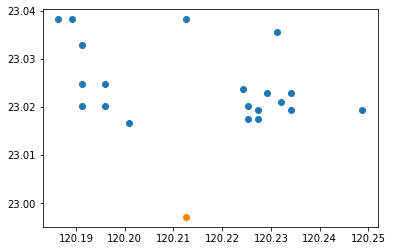

In [ ]:
# plot top peaks position consider hotels and convenience stores 
select_num = 20
plt.scatter(peak_position[:select_num,0],peak_position[:select_num,1])
plt.scatter(np.array(x_y_tr)[:,0],np.array(x_y_tr)[:,1]) # train station

In [ ]:
search_center = peak_position[0]
filter_f = partial(filter_by_criteria , center = search_center , criteria = 200 )
filtered_hotel = list(filter(filter_f , Tainan_all_objects['Tainan_hotel']))
#for name , posi , rat  in zip(name_h ,x_y_h , rating_h):
#  if posi in res and rat > 4.5:
#    print(name)

In [ ]:
d = []
for obj in filtered_hotel:
  if 'source_rating' in obj.__dict__.keys() and float(obj.source_rating) > 8.5:
    print(f" rating : {obj.source_rating} , name : {obj.source_name}")
    d.append(obj)

 rating :  8.8  , name : 香格里拉台南遠東國際大飯店
 rating :  8.6  , name : 老曼船長青年旅館


# Django parts of ORM models 

In [ ]:
# from ORM object to hotel object ...
# May be it can combine with Hotel class

class Meta_Store(models.Model):

    store_type = 
    name =
    location =
    rating =
    admin_area =
    address =
    place_id =

    class meta():
      abstract = True

class Resturant(Meta_Store):

  @classmethod
  def create_obj_by_dict(cls , store_dict):
    
    # basic attribute
    store_type = store_dict['store_type']
    name = store_dict['store_name']
    location = store_dict['location']
    rating = store_dict['rating']
    admin_area = store_dict['admin_area']
    address = store_dict['address']
    place_id = store_dict['place_id']

    return cls.create(name=name,
          location=location,
          rating=rating,
          admin_area=admin_area,
          address=address,
          place_id=place_id,
          ...
          )


class Hotel(Meta_Store):
    """ Ordered Item Model """

    room_source =
    source_name = 

    detail_href =
    comment_num =
    star =
    pic_link =
    source_rating =
    pics =
    comments =

  @classmethod
  def create_obj_by_dict(cls , store_dict):
    
    # update basic attribute
    store_type = store_dict['store_type']
    name = store_dict['store_name']
    location = store_dict['location']
    rating = store_dict['rating']
    admin_area = store_dict['admin_area']
    address = store_dict['address']
    place_id = store_dict['place_id']

    # create ORM objects
    return cls.create(# basic property 
              store_type = store_type , # char
              name = name , # char
              lng = lng , # float 
              lat = lat , # float
              rating = rating , # float 
              admin_area = admin_area , # char
              address = address , # char
              place_id = place_id , # char 

              # source property (create by compare_hotel_name method)
              room_source = None , # char
              source_name = None , # char 

              # detail property (create by create_attr_by_request method)
              detail_href = None , # char 
              comment_num = None , # int
              star = None , # int 
              pic_link = None , # Many Image 
              source_rating = None , # float
              pics = None , # Image
              comments = None # Many char
          )
    
  def compare_hotel_name(self , distance_threshold = 150 ):

    # First step : get latlng in booking from place_id in gmaps , and check the latlng close or not
    place_id_gmap = self.place_id
    booking_latlng , name_booking , address_booking = get_detail_hotel_information(place_id = place_id_gmap , return_name_address = True )
    print(f'latlng_booking : {booking_latlng} , latlng_gmap : {self.location} ')
    print(f'The booking name is : {name_booking}')
    
    # Second step : Name judgement (gmap name vs. booking name)
    common_word_count , max_len_chars = find_common_word_2str(self.name , name_booking)
    name_judge = common_word_count >= 2

    # Third step : distance judgement (by place id input and get latlng result)
    delta_distance = distance(self.location , booking_latlng)
    distance_judge = delta_distance < distance_threshold 

    print(f'Distance = {delta_distance} meters')
    print(f'There is {common_word_count} same words {max_len_chars}')

    if name_judge and distance_judge:
      self.room_source = 'booking'
      self.source_name = name_booking 
      print(f'Booking contain this hotel : {name_booking}')

    else:
      self.room_source = None
      self.source_name = None 
      print(f'This hotel {name_booking} is not the same hotel as {self.name}!')

    self.save()

  def create_attr_by_request(self , date = None , instant = False ):
    
    if self.source_name == None :

      print("[WARNING] No source_name and room_source , now scrape it !" )
      self.compare_name_between_gmap_booking() # compare and modify hotel name between gmap and booking

    # scraper for booking source
    if self.room_source == 'booking' and self.source_name :

      if instant:     

        self.date = date # first day to check in
        if self.date != None:
          
          instant_dict = get_hotel_information( hotel_name = self.source_name , date = date ,  instant_information = True )

          self.room_recommend = instant_dict['room_recommend'] 
          self.room_remainings = instant_dict['room_remainings'] 
          self.hot = instant_dict['hot']
          self.price = instant_dict['price']
          self.instant_hrefs = instant_dict['instant_hrefs']

          # TODO : 這邊要給一個例外, 如果 room_recommend ,room_remainings 等等皆為已售完 , 則抓取前後兩天房源 ! (需有個地方儲存以便顯示)
          # => get_hotel_information( self.source_name , date = date +/- 1,2 ,  instant_information = True )

        else :
          print('[WARNING] No date assigned!')
        
      
      # 此處用在第一次建立 hotel objects 時所用 
      else:

        date = ['2020-12-16','2020-12-17'] #
        static_dict = get_hotel_information( hotel_name = self.source_name , date = date ,  instant_information = False )
        
        self.detail_href = static_dict['href']
        self.comment_num = static_dict['comment_num']
        self.star = static_dict['stars']
        self.pic_link = static_dict['pic_link']
        self.source_rating = static_dict['source_rating']
        
        static_dict_deatil = get_detail_hotel_information( self.detail_href )

        self.pics = static_dict_deatil['pics']
        self.comments = static_dict_deatil['comments']
      
      self.save() # update data to database
    
    elif self.room_source == 'agoda:':
      pass
    else :
      pass





  def __repr__(self):
    return f'{self.store_type} : {self.name} is at {self.location} in {self.admin_area} and rating {self.rating} in googlemap '

  #https://stackoverflow.com/questions/6423814/is-there-a-way-to-check-if-two-object-contain-the-same-values-in-each-of-their-v
  def __eq__(self , other):
    # need to modified , ex : compare dict['name'] or dict['address'] ....
    return self.__dict__ == other.__dict__

  def __getitem__(self , ):
    pass
    # TODO : 打 self.name 就能回傳物件

In [ ]:
'''
date = ['2020-12-10','2020-12-11']
payload , headers = get_header_payload( date , 
                      target_hotel = '安心 林的家民宿' ,  
                      destination_admin = '台南' )
soup = send_request( url , method = 'POST' , data = payload , headers = headers)
soup_content = soup.find_all( "div" , { 'class' : "sr_item_content sr_item_content_slider_wrapper "})[0]
#print(soup_content.prettify())
res = str(soup_content.find('div' , { 'class' : "bui-price-display"}))
int(get_digits(res.split('$')[1])[0])
#"prco-inline-block-maker-helper prco-f-font-display_one bui-f-color-grayscale-darker"
# bui-price-display__value prco-inline-block-maker-helper bui-f-color-constructive
'''